# Projet P3

`Auteur` : Romain Capocasale (INF3dlm-a)

`Date` : 01.10.2019

`Version de python` : 3.7.1

`Description` : Notebook python avec les techniques de DeepLearning

# Importation

In [42]:
%matplotlib inline

import re
import os
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import gensim

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPool1D
from keras.layers import Flatten
from keras.initializers import Constant

# Chragement du jeu de données

In [85]:
dataset = pd.read_json('dataset/financialData.json')

# Suppression des phrases avec un sentiment entre -0.1 et 0.1
Les phrases avec un sentiment compris entre -0.1 et 0.1 influence en mal la précision. En effet, si le système prédit un sentiment de 0.05 pour une phrase alors que son sentiment réel et de -0.05 la prédiction sera considéré come fausse. Alors qu'en réalité l'erreur commise est toute petite (0.10).
On voit que l'on perd 283 phrase a cause de ce processus.

In [86]:
print("size before : {}".format(len(dataset)))
dataset.drop(dataset[(dataset.sentiment >= -0.1) & (dataset.sentiment <= 0.1)].index, inplace=True)
print("size after : {}".format(len(dataset)))

size before : 2866
size after : 2583


# Séparation des observations et des étiquettes
Le sentiment est une valeur continue comprise entre -1 et 1. On transforme cette intervale continue en 2 valeurs discrete 0 et 1. Le modèle sera entrainé comme un classificateur, 0 pour une phrase négative et 1 pour une phrase positive.

In [9]:
X = np.array(dataset['title'])
y = np.array([1 if s >= 0 else 0 for s in dataset['sentiment']])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [11]:
size, a_size, b_size = len(X_train), list(y_train).count(1), list(y_train).count(0)
print('Train set')
print('\tSize :', size)
print(f'\tNumber of "pos" : {a_size} ({"%.2f" % (100*a_size/size)}%)')
print(f'\tNumber of "neg" : {b_size} ({"%.2f" % (100*b_size/size)}%)')
print(f'\tRatio "pos"/"neg" : {"%.5f" % (a_size/b_size)}')

size, a_size, b_size =  len(X_test), list(y_test).count(1), list(y_test).count(0)
print('Test set')
print(f'\tSize : {size}')
print(f'\tNumber of "pos" : {a_size} ({"%.2f" % (100*a_size/size)}%)')
print(f'\tNumber of "neg" : {b_size} ({"%.2f" % (100*b_size/size)}%)')
print(f'\tRatio "pos"/"neg" : {"%.5f" % (a_size/b_size)}')

Train set
	Size : 2066
	Number of "pos" : 1301 (62.97%)
	Number of "neg" : 765 (37.03%)
	Ratio "pos"/"neg" : 1.70065
Test set
	Size : 517
	Number of "pos" : 326 (63.06%)
	Number of "neg" : 191 (36.94%)
	Ratio "pos"/"neg" : 1.70681


Le découpage entre les valeurs d'entrainement et de test sont effectués de manière stratifié. Cela veut dire qu'il y aura la meme répartion de phrase positive et négative entre le jeu d'entrainement et celui de test.

# Traitement du texte
Le traitement du texte est effectué avec la librairie spacy. Les opérations suivante sont effectués sur les phrases:
* conservation uniquement des verbes, averbes, noms et adjectifs
* lemmantization des mots
* suppresion de la ponctuation
* suppresion des mots ne contenant pas des charactère alphanumérique
* suppresion des mots commencants par un $

In [50]:
reg_alpha = re.compile(r"^[A-Za-z]*$")
reg_remove_word_with_dollar = re.compile(r"\$\S*")
nlp = spacy.load('en')
good_words = ['VERB', 'ADV', 'NOUN', 'ADJ']

def text_preprocessor(sentence):
    final_sentence = []
    for word in nlp(sentence):
        if word.pos_ not in good_words:
            continue 
            
        lemma_word = word.lemma_.lower()
        if (lemma_word not in string.punctuation) and reg_alpha.match(lemma_word) and not reg_remove_word_with_dollar.match(lemma_word):
            final_sentence.append(lemma_word)
    return ' '.join(final_sentence)

In [51]:
X_train_preprocessed = []
for sentence in X_train:
    X_train_preprocessed.append(text_preprocessor(sentence))
    
X_test_preprocessed = []
for sentence in X_test:
    X_test_preprocessed.append(text_preprocessor(sentence))

# Word embedding

In [52]:
tokenizer_obj =  Tokenizer()

tokenizer_obj.fit_on_texts(dataset['title'])

max_length = max([len(s.split()) for s in dataset['title']])

vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train_preprocessed)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test_preprocessed)

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

# Création du réseau de neuronne
Réseau de neuronne de type LSTM inspiré du tutorial : https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

In [89]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrainement du modèle
Le modèle est entrainé avec des echantillons de 256 données, avec 25 epochs

In [90]:
history = model.fit(X_train_pad, y_train, batch_size=256, epochs=25, verbose=2, validation_data=(X_test_pad, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2066 samples, validate on 517 samples
Epoch 1/25
 - 1s - loss: 0.6689 - accuracy: 0.6297 - val_loss: 0.6609 - val_accuracy: 0.6306
Epoch 2/25
 - 1s - loss: 0.6598 - accuracy: 0.6297 - val_loss: 0.6605 - val_accuracy: 0.6306
Epoch 3/25
 - 1s - loss: 0.6592 - accuracy: 0.6297 - val_loss: 0.6602 - val_accuracy: 0.6306
Epoch 4/25
 - 1s - loss: 0.6640 - accuracy: 0.6297 - val_loss: 0.6586 - val_accuracy: 0.6306
Epoch 5/25
 - 1s - loss: 0.6599 - accuracy: 0.6297 - val_loss: 0.6615 - val_accuracy: 0.6306
Epoch 6/25
 - 1s - loss: 0.6612 - accuracy: 0.6297 - val_loss: 0.6595 - val_accuracy: 0.6306
Epoch 7/25
 - 1s - loss: 0.6592 - accuracy: 0.6297 - val_loss: 0.6581 - val_accuracy: 0.6306
Epoch 8/25
 - 1s - loss: 0.6577 - accuracy: 0.6297 - val_loss: 0.6557 - val_accuracy: 0.6306
Epoch 9/25
 - 1s - loss: 0.6088 - accuracy: 0.6418 - val_loss: 0.5257 - val_accuracy: 0.7369
Epoch 10/25
 - 1s - loss: 0.4161 - accuracy: 0.8543 - val_loss: 0.5543 - val_accuracy: 0.7621
Epoch 11/25
 - 1s - lo

# Evaluation du modèle
On remarque que la précison sur le jeu d'entrainement est de 96 % et de 79 % sur le jeu de test. On peut donc déduire que le modéle surévalue. On peut également remarquer que la perte augemente sur le jeu de test alors qu'elle devait diminuer.

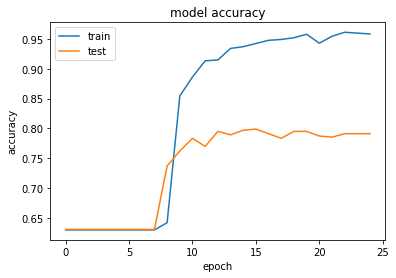

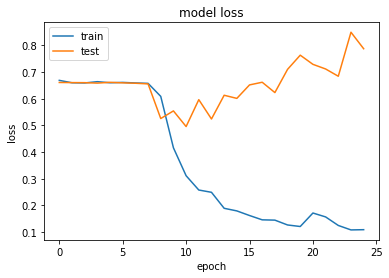

Training Accuracy: 0.9632
Testing Accuracy:  0.7911


In [98]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

## Matrice de confusion
On peut voir que 132 phrases néagtaive on été correctement prédite, 49 phrase négative ont été incorectement prédite, 59 phrases psotive ont été incorectement prédite et 277 positive ont été corectment prédite.

In [99]:
y_pred = model.predict_classes(X_test_pad)
confusion_matrix(y_pred ,y_test)

array([[132,  49],
       [ 59, 277]], dtype=int64)

# Affichage des phrases incorrectement prédite
la méthode `getModelError` retourne une liste des phrasesfaux postive et faux négative

In [102]:
def getModelError(y_pred, y_test, X_test):
'''
This method return false positive sentence and false negative sentence

y_pred -- predicted value
y_test -- true test value
X_test -- test sentence
'''
    X_test_list = X_test.tolist()
    falsePositiveSentence = []
    falseNegativeSentence = []
    for i in range(0,len(y_pred)):
        if y_test[i] == 1 and y_pred[i] == 0:
            falsePositiveSentence.append(X_test_list[i])
        elif y_test[i] == 0 and y_pred[i] == 1:
            falseNegativeSentence.append(X_test_list[i])
    return (falsePositiveSentence, falseNegativeSentence)

In [103]:
falsePositive, falseNegative = getModelError(y_pred, y_test, X_test)

In [104]:
print(falsePositive)

['CompaniesRBS pulls a surprise: a 27% jump in profits', 'BP wins right to appeal some Gulf spill damages claims', 'Diageo sells wine businesses for 320m pounds', 'GlaxoSmithKline beats profit forecasts despite Advair hit, lower margins', "WPP's Sir Martin Sorrell is highest-paid FTSE 100 chief executive", 'offers will take place until next week ', 'Friday Papers: Sir Philip Green sells BHS for Ã‚Â£1', 'amazon just signed a deal to lease 20 Boeing 767 cargo planes ', 'Travis Perkins to create 4000 jobs', 'CompaniesSanofi poaches immunology expert from AstraZeneca', 'shorts breakin flag ', 'Daily Mail And General Trust eyeing Yahoo! ', 'European shares fall on Chinese import data, SABMiller soars', 'acting tough on big volume against the tape ', 'Friday was last chance under $2 ', "AstraZeneca's $727 million play to do away with chemotherapy", 'Tesco share price closes higher as two more directors leave grocer', 'SSE share price: Peterhead station to supply voltage support to National G

# Word2vec
Word2vec consiste à rapprocher les mots semblables proche dans un espace de plusieurs dimension. J'ai téléchargé sur le site de glove un fichier contenant une matrice avec des valeurs précalculé pour plusieurs mots de la langues anglaises. Le code ci-dessous récupére cette matrice stocké dans le fichier `glove/glove.100d.txt` et garde seulement les mots présents dans notre jeu de données. 

In [107]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [109]:
embedding_matrix = create_embedding_matrix('glove/glove.6B.100d.txt', tokenizer_obj.word_index, EMBEDDING_DIM)

In [111]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print("Percentage of the word of the dataset present in the matrix : {} % ".format((nonzero_elements / vocab_size)*100))

Percentage of the word of the dataset present in the matrix : 89.43323727185398


# Création du modèle
Cette fois ci le modèle choisi est un réseau de neuronne récurrent inspiré du site : https://realpython.com/python-keras-text-classification/#what-is-a-word-embedding. La matrice de mot est également utilisé.

In [118]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length, weights=[embedding_matrix]))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [122]:
history = model.fit(X_train_pad, y_train,epochs=25,verbose=2,validation_data=(X_test_pad, y_test),batch_size=256)

Train on 2066 samples, validate on 517 samples
Epoch 1/25
 - 0s - loss: 0.0669 - accuracy: 0.9690 - val_loss: 0.6831 - val_accuracy: 0.7872
Epoch 2/25
 - 0s - loss: 0.0665 - accuracy: 0.9710 - val_loss: 0.6912 - val_accuracy: 0.7853
Epoch 3/25
 - 0s - loss: 0.0663 - accuracy: 0.9700 - val_loss: 0.6913 - val_accuracy: 0.7834
Epoch 4/25
 - 0s - loss: 0.0656 - accuracy: 0.9685 - val_loss: 0.6937 - val_accuracy: 0.7853
Epoch 5/25
 - 0s - loss: 0.0651 - accuracy: 0.9700 - val_loss: 0.6936 - val_accuracy: 0.7872
Epoch 6/25
 - 0s - loss: 0.0644 - accuracy: 0.9700 - val_loss: 0.7021 - val_accuracy: 0.7853
Epoch 7/25
 - 0s - loss: 0.0637 - accuracy: 0.9705 - val_loss: 0.7045 - val_accuracy: 0.7872
Epoch 8/25
 - 0s - loss: 0.0629 - accuracy: 0.9695 - val_loss: 0.7080 - val_accuracy: 0.7853
Epoch 9/25
 - 0s - loss: 0.0628 - accuracy: 0.9710 - val_loss: 0.7144 - val_accuracy: 0.7814
Epoch 10/25
 - 0s - loss: 0.0622 - accuracy: 0.9710 - val_loss: 0.7113 - val_accuracy: 0.7814
Epoch 11/25
 - 0s - lo

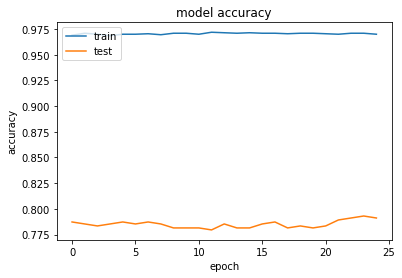

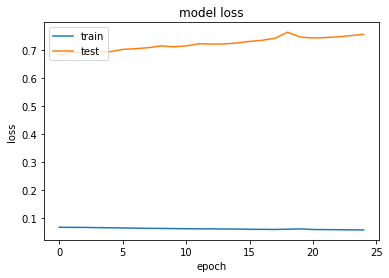

Training Accuracy: 0.9710
Testing Accuracy:  0.7911


In [123]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))